In [1]:
%matplotlib inline
import datetime
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from graspy.simulations import er_np, sbm
from graspy.inference import LatentDistributionTest
from sklearn.metrics.pairwise import pairwise_kernels

In [2]:
def mc_iter(n, m, p, q, test_type, i=1):
    ns = np.random.multinomial(n, [0.4, 0.3, 0.3])
    ms = np.random.multinomial(m, [0.4, 0.3, 0.3])
    
    X_graph = sbm(ns, p)
    Y_graph = sbm(ms, q)

    def metric_func(X, Y=None, workers=None):
        return pairwise_kernels(X, Y, metric="rbf", gamma=2)
    
    ldt = LatentDistributionTest(test="hsic",
                                 metric=metric_func,
                                 n_components=1,
                                 workers=cpu_count()-2,
                                 size_correction=test_type,)
    pval = ldt.fit_predict(X_graph, Y_graph)

    return pval

In [3]:
def monte_carlo(n, m, p, q, test_type=False, mc_iters=10):
    '''
    n: size of the first graph
    m: size of the second graph
    p: latent position of the first graph
    q: latent poisiton of the second graph
    test_type: boolean, to set size_correction
    mc_iters: number of monte-carlo-iterations
    '''
    pvals = [None] * mc_iters
    for i in tqdm(range(mc_iters)):
        pvals[i] = mc_iter(n, m, p, q, test_type)

    return np.array(pvals)

In [4]:
thetas = [1.20, 1.00, 0.80]
omegas = [0.05, 0.10, 0.00]
r = 0.9
latent_position_1 = np.array([r * np.sin(thetas[0]),
                              r * np.cos(thetas[0]),
                              r * np.sin(omegas[0])])
latent_position_2 = np.array([r * np.sin(thetas[1]),
                              r * np.cos(thetas[1]),
                              r * np.sin(omegas[1])])
latent_position_3 = np.array([r * np.sin(thetas[2]),
                              r * np.cos(thetas[2]),
                              r * np.sin(omegas[2])])
latent_position_matrix = np.vstack([latent_position_1,
                                    latent_position_2,
                                    latent_position_3])
latent_position_matrix

array([[0.83883518, 0.32612198, 0.04498125],
       [0.75732389, 0.48627208, 0.08985007],
       [0.64562048, 0.62703604, 0.        ]])

In [5]:
probability_matrix = latent_position_matrix @ latent_position_matrix.T
np.linalg.matrix_rank(probability_matrix)

3

In [6]:
probability_matrix

array([[0.81202331, 0.7978955 , 0.74605941],
       [0.7978955 , 0.81807304, 0.79385393],
       [0.74605941, 0.79385393, 0.81      ]])

In [7]:
mc_iters = 1000
ns = [50, 100, 200, 300, 400, 500]
cs = [1, 2, 5, 7, 10, 15]

p = probability_matrix
q = probability_matrix

The following (commented out) cell runs the simulation from scratch if uncommented. Depending on your system it can take hours, or even days with the settings provided by default. To run a smaller simulation, decrease the number of monte carlo simulations, graph orders, or grapher order ratios used. If the following cell is not uncommented, the notebook will use data from our run to generate the figure.

In [8]:
# full_data = {}
# part_data = {}
# for c in cs:
#     print(str(datetime.datetime.now()) + ' current c: {}'.format(c))
#     print(str(datetime.datetime.now()) + ' unmodified ASE')
#     tests_size_sbm_unmodified = np.array([monte_carlo(n=i, m=c*i, p=p, q=q,
#                                                      mc_iters=mc_iters,
#                                                      test_type=False)
#                                          for i in ns])
#     print(str(datetime.datetime.now()) + ' corrected ASE')
#     tests_size_sbm_sampling = np.array([monte_carlo(n=i, m=c*i, p=p, q=q,
#                                                    mc_iters=mc_iters,
#                                                    test_type=True)
#                                        for i in ns])
#     # store every result of every test
#     full_data[c] = {'unmodified': tests_size_sbm_unmodified,
#                     'sampling': tests_size_sbm_sampling}
#     # store only the powers
#     size_sbm_unmodified = np.array([np.sum(i < 0.05)/mc_iters for i in tests_size_sbm_unmodified])
#     size_sbm_sampling = np.array([np.sum(i < 0.05)/mc_iters for i in tests_size_sbm_sampling])
#     part_data[c] = {'unmodified': size_sbm_unmodified,
#                     'sampling': size_sbm_sampling}
    
#     # pkl.dump(full_data, open( "../data/graphs_sbm_size_full.pkl", "wb" ) )
#     pkl.dump(part_data, open( "../data/graphs_sbm_size_part.pkl", "wb" ) )

In [9]:
part_data = pkl.load(open( "../data/graphs_sbm_size_part.pkl", "rb" ) )

In [10]:
part_data

{1: {'unmodified': array([0., 0., 0., 0., 0., 0.]),
  'sampling': array([0., 0., 0., 0., 0., 0.])},
 2: {'unmodified': array([0., 0., 0., 0., 0., 0.]),
  'sampling': array([0., 0., 0., 0., 0., 0.])},
 5: {'unmodified': array([0.416, 0.976, 0.993, 0.936, 0.573, 0.212]),
  'sampling': array([0., 0., 0., 0., 0., 0.])},
 7: {'unmodified': array([0.956, 1.   , 1.   , 1.   , 0.943, 0.573]),
  'sampling': array([0., 0., 0., 0., 0., 0.])},
 10: {'unmodified': array([0.999, 1.   , 1.   , 1.   , 0.997, 0.85 ]),
  'sampling': array([0., 0., 0., 0., 0., 0.])},
 15: {'unmodified': array([1.   , 1.   , 1.   , 1.   , 1.   , 0.974]),
  'sampling': array([0., 0., 0., 0., 0., 0.])}}

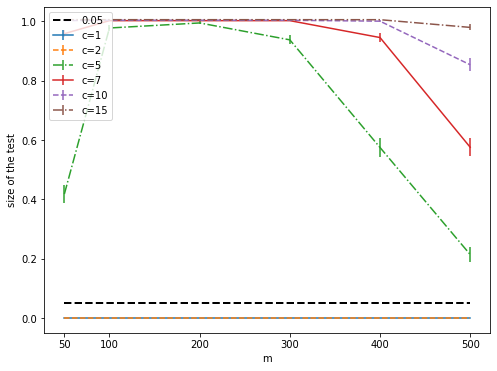

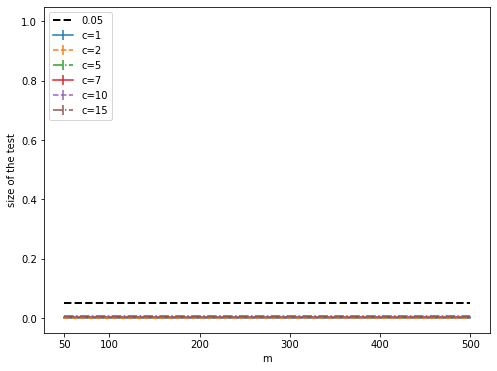

In [11]:
graph_type = 'sbm'
size_power = 'size'
styles=['-', '--', '-.', '-', '--', '-.']

for kernel_type in ['unmodified', 'sampling']:
    fig01, ax01 = plt.subplots(1, 1, figsize=(8,6))
    for j, c in enumerate(cs):
        to_plot = part_data[c][kernel_type]
            
        ax01.errorbar(x = ns, y=to_plot+c*0.0004, fmt=styles[j],
                      yerr=1.96*np.sqrt(to_plot*(1-to_plot)/mc_iters),
                      label='c={}'.format(c))
    ax01.plot(ns, np.ones(len(ns)) * 0.05, 'k--', label='0.05', linewidth=2)
    ax01.set_xlabel("m")
    ax01.set_ylabel("{} of the test".format(size_power))
    ax01.set_ylim([-0.05, 1.05])
    ax01.set_xticks(ns)
    # ax01.legend(bbox_to_anchor=(1.04,1), loc="upper left");
    ax01.legend(loc="upper left")
    fig01.savefig('../figures/graphs_{}_{}_{}'.format(graph_type, size_power, kernel_type),
                  bbox_inches='tight', dpi=300);